In [220]:
import cv2 as cv
import skimage
from skimage.filters import frangi
import skimage.morphology as mp
from glob import glob
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
def split_image(image, tile_size=4, step=None):
    gray = (len(image.shape) == 2) or (image.shape[2] == 1)
    if not step: step = tile_size
    return view_as_windows(image, (tile_size, tile_size), step=step).reshape(-1, tile_size, tile_size) if gray else view_as_windows(
        image, (tile_size, tile_size, 3), step=step).reshape(-1, tile_size, tile_size, 3)


def get_features(image):
    channels = image.reshape(-1, 3)
    mean, std = np.mean(channels, axis=0), np.std(channels, axis=0)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mom = cv2.moments(gray)
    hu = cv2.HuMoments(mom)[:, 0]
    sp, nu = [mom[k] for k in sp_key], [mom[k] for k in nu_key]
    return np.hstack([mean, std, hu, sp, nu])


def create_meta_data_row(row, step=None):
    image, label = row['original'], row['labeled']
    image = cv2.fastNlMeansDenoisingColored(image,None,5,5,7,21)
    X = np.array([get_features(x) for x in split_image(image, step=step)])
    y = split_image(image, step=step)[:, 3, 3] > 0
    return X, y


def meta_data(data):
    total = pd.DataFrame()
    for _, row in tqdm(list(data.iterrows())):
        X, y = create_meta_data_row(row, step=1)
        chunk = pd.DataFrame(data=X, columns=features)
        chunk['id'] = row.id
        chunk['label'] = y
        total = pd.concat([total, chunk])
    return total.reset_index(drop=True)

def resize_data(dataset):
    new_dataset = list()
    dim = (876, 584)
    for image in dataset:
        new_dataset.append(cv2.resize(image, dim, interpolation = cv2.INTER_AREA))
    return dataset

In [277]:
def preprocess(img):
    img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
    img_green = img[:, :, 1]
    img = np.zeros(img.shape)
    img[:, :, 1] = img_green
    img = cv.cvtColor(img.astype(np.uint8), cv.COLOR_BGR2GRAY)
    img = cv.GaussianBlur(img, (3,3), 0)
    plt.figure()    
    plt.imshow(img, 'gray')
    return img

In [278]:
def main_processing(img):
    img = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 31, 2)
    img = 255 - img
    plt.figure()    
    plt.imshow(img, 'gray')
    
    mask = np.zeros_like(img)
    contours = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    area_thresh = 60
    for cntr in contours:
        area = cv.contourArea(cntr)
        if area > area_thresh:
            cv.drawContours(mask, [cntr], -1, 255, 2)
    
    img = cv.bitwise_and(img, mask)
    kernel = np.ones((5,5), np.uint8)
    img = cv.dilate(img, kernel, iterations=1)
    
    plt.figure()    
    plt.imshow(img, 'gray')
    return img

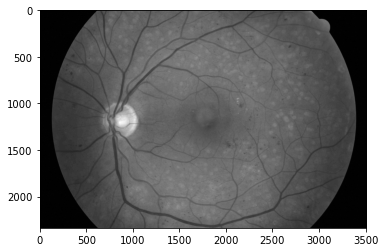

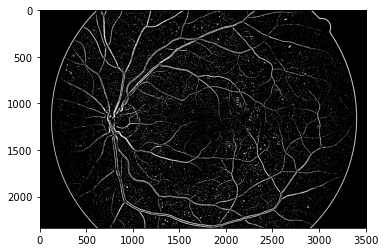

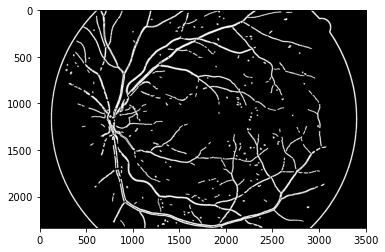

In [279]:
files = glob('images/*')
#print(files)
for file in files:
    img = cv.imread(file)
    #img = cv.resize(img, (1500,1500))
    img = preprocess(img)
    img = main_processing(img)
    break